In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# Charger les données (ajustez les chemins si nécessaire)
sales = pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Sales.xlsx")
products = pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Products_f.xlsx")
sections = pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Sections.xlsx")
customers = pd.read_excel(r"C:\Users\GSI\Desktop\DataWareHouse\Customers_f.xlsx")

print("Shapes :")
print("Sales:", sales.shape)
print("Products:", products.shape)
print("Sections:", sections.shape)
print("Customers:", customers.shape)

Shapes :
Sales: (502500, 12)
Products: (154, 6)
Sections: (57, 2)
Customers: (3900, 10)


In [4]:
# Fusions des données
ml_df = sales.merge(products, on="SKU", how="left")
ml_df = ml_df.merge(customers, on="code_customer", how="left")
ml_df = ml_df.merge(sections, on="section_no", how="left")

# Filtrer sections Women
female_sections = [
    "Womens Everyday Basics", "Womens Lingerie", "Womens Nightwear, Socks & Tigh",
    "Womens Small accessories", "Womens Big accessories", "Womens Swimwear, beachwear",
    "Womens Everyday Collection", "Womens Trend", "Womens Shoes", "Womens Tailoring",
    "Womens Casual", "Womens Premium", "Womens Jackets", "Ladies Denim",
    "Ladies H&M Sport", "Ladies Other", "Contemporary Street", "Contemporary Casual", "Contemporary Smart"
]

df_women = ml_df[ml_df["section_name"].isin(female_sections)].copy()

# Compter achats par cliente/sous-section
customer_subsection_counts = (
    df_women.groupby(["code_customer", "section_name"])
    .size()
    .reset_index(name="count")
)

# Sous-section dominante
main_subsection = customer_subsection_counts.loc[
    customer_subsection_counts.groupby("code_customer")["count"].idxmax()
].copy()
main_subsection.rename(columns={"section_name": "main_women_subsection"}, inplace=True)

# Merge
df_final = df_women.merge(
    main_subsection[["code_customer", "main_women_subsection"]],
    on="code_customer", how="left"
)

# Filtrer les deux classes
df_binary = df_final[
    df_final["main_women_subsection"].isin([
        "Womens Small accessories", "Womens Nightwear, Socks & Tigh"
    ])
].copy()

# Une ligne par cliente
df_clients = df_binary.drop_duplicates(subset="code_customer").copy()

# Agrégations produits
prod_agg = (
    df_women.groupby("code_customer")
    .agg(
        n_women_purchases=("code_sale", "count"),
        n_orders=("code_order", "nunique"),
        n_unique_sku=("SKU", "nunique"),
        avg_price=("Estimated_Unit_Price", "mean"),
        std_price=("Estimated_Unit_Price", "std"),
        min_price=("Estimated_Unit_Price", "min"),
        max_price=("Estimated_Unit_Price", "max"),
        avg_quantity=("quantity", "mean"),
        n_unique_style=("Style_code", "nunique"),
        n_unique_color=("code_color", "nunique"),
    )
    .reset_index()
)
prod_agg["std_price"] = prod_agg["std_price"].fillna(0)

# Oversampling léger
df_bal = pd.concat([
    df_clients[df_clients["main_women_subsection"] == "Womens Nightwear, Socks & Tigh"],
    df_clients[df_clients["main_women_subsection"] == "Womens Small accessories"].sample(1500, replace=True)
]).reset_index(drop=True)

# Fusion features
df_enriched = df_bal.merge(prod_agg, on="code_customer", how="left")

# Nettoyage
df_enriched["Overall_review"] = (
    df_enriched["Overall_review"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)
df_enriched["Age"] = pd.to_numeric(df_enriched["Age"], errors="coerce")
df_enriched = df_enriched.dropna(subset=["Age", "Overall_review"])

print("Shape final:", df_enriched.shape)

Shape final: (4877, 38)


In [5]:
# Préparation des features
feature_cols = [
    "Age", "Gender", "Zip_code", "Preferred_size", "Overall_review",
    "Subscription Status", "Previous Purchases", "Payment Method", "Frequency of Purchases",
    "n_women_purchases", "n_orders", "n_unique_sku", "avg_price", "std_price",
    "min_price", "max_price", "avg_quantity", "n_unique_style", "n_unique_color"
]

X = df_enriched[feature_cols].copy()
y = df_enriched["main_women_subsection"]

# Encoder les features catégorielles
from sklearn.preprocessing import LabelEncoder
cat_cols = ["Gender", "Zip_code", "Preferred_size", "Subscription Status", "Payment Method", "Frequency of Purchases"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])

# Modèle RandomForest
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train, y_train)

print("Modèle entraîné !")

Train size: 3901 | Test size: 976
Modèle entraîné !


Accuracy: 0.9651639344262295

Classification Report:
                                precision    recall  f1-score   support

Womens Nightwear, Socks & Tigh       0.95      1.00      0.98       676
      Womens Small accessories       0.99      0.89      0.94       300

                      accuracy                           0.97       976
                     macro avg       0.97      0.95      0.96       976
                  weighted avg       0.97      0.97      0.96       976



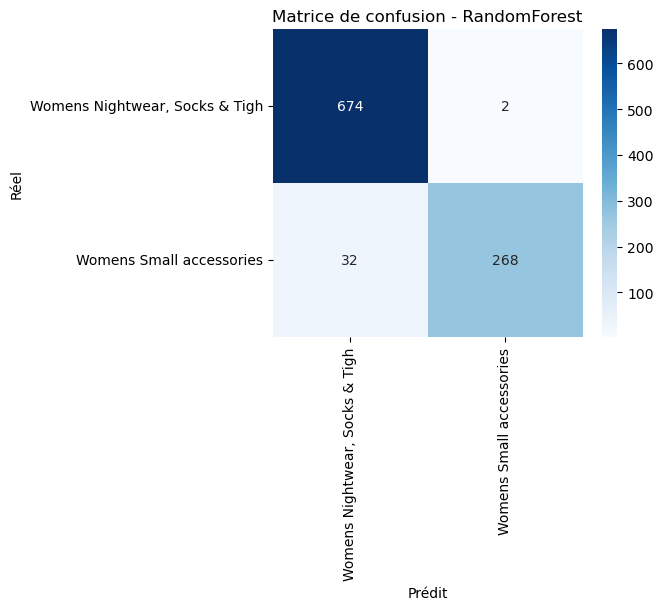


Importance des variables:
                   feature  importance
12               avg_price    0.151198
13               std_price    0.111111
2                 Zip_code    0.073618
16            avg_quantity    0.072438
0                      Age    0.071110
6       Previous Purchases    0.064317
4           Overall_review    0.061085
17          n_unique_style    0.059027
9        n_women_purchases    0.054786
10                n_orders    0.053933
11            n_unique_sku    0.052669
18          n_unique_color    0.041134
8   Frequency of Purchases    0.036563
7           Payment Method    0.032083
3           Preferred_size    0.025318
14               min_price    0.019235
1                   Gender    0.011085
5      Subscription Status    0.008860
15               max_price    0.000431


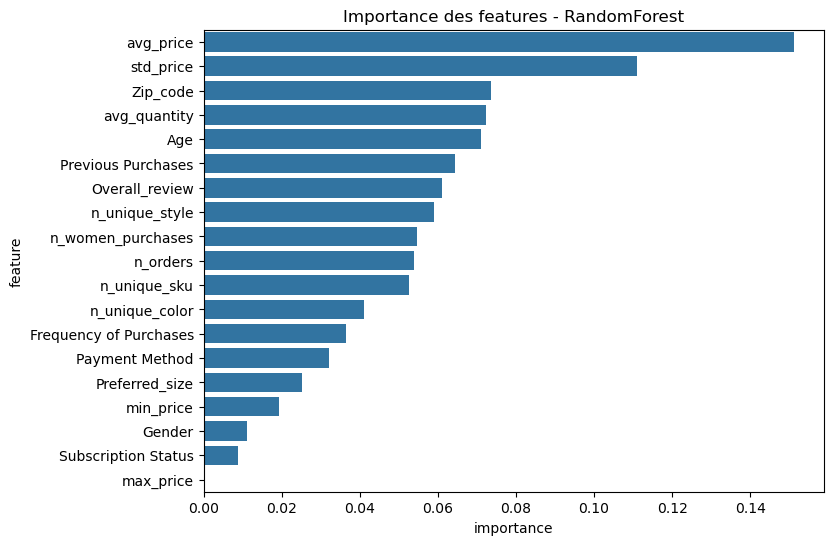

In [6]:
# Évaluation
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - RandomForest")
plt.show()

# Importance des features
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nImportance des variables:")
print(feat_imp)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Importance des features - RandomForest")
plt.show()

In [8]:
# Sauvegarder le modèle
joblib.dump(model, 'women_preference_model.pkl')
joblib.dump(encoders, 'encoders.pkl')
print("Modèle et encodeurs sauvegardés !")

# Pour tester une prédiction
# Exemple d'input
input_data = {
    "Age": 25,
    "Gender": "F",
    "Zip_code": "12345",
    "Preferred_size": "M",
    "Overall_review": 4.5,
    "Subscription Status": "Yes",
    "Previous Purchases": 10,
    "Payment Method": "Credit Card",
    "Frequency of Purchases": "Weekly",
    "n_women_purchases": 5,
    "n_orders": 3,
    "n_unique_sku": 4,
    "avg_price": 50,
    "std_price": 10,
    "min_price": 30,
    "max_price": 70,
    "avg_quantity": 1,
    "n_unique_style": 2,
    "n_unique_color": 3
}

# Encoder
df_input = pd.DataFrame([input_data])
for col in cat_cols:
    df_input[col] = encoders[col].transform(df_input[col].astype(str))

prediction = model.predict(df_input)[0]
print("Prédiction pour l'exemple:", prediction)

Modèle et encodeurs sauvegardés !


ValueError: y contains previously unseen labels: 'F'

In [15]:
# Charger le modèle et les encodeurs sauvegardés


print("Classes du modèle:", model.classes_)
print("Valeurs Zip_code disponibles:", encoders['Zip_code'].classes_[:10], "...")  # Afficher les 10 premiers

cat_cols = ["Gender", "Zip_code", "Preferred_size", "Subscription Status", "Payment Method", "Frequency of Purchases"]

# Utiliser un zip code qui existe dans les données d'entraînement
zip_sample = encoders['Zip_code'].classes_[0]  # Prendre le premier disponible

# Test Data 1: Haute Préférence Femmes (Nightwear/Lingerie) - profil typique
test_data_1 = {
    "Age": 25, "Gender": "Female", "Zip_code": zip_sample, "Preferred_size": "M",
    "Overall_review": 4.8, "Subscription Status": "Yes", "Previous Purchases": 30,
    "Payment Method": "Credit Card", "Frequency of Purchases": "Weekly",
    "n_women_purchases": 25, "n_orders": 15, "n_unique_sku": 20,
    "avg_price": 75.00, "std_price": 20.00, "min_price": 50.00, "max_price": 150.00,
    "avg_quantity": 2.0, "n_unique_style": 12, "n_unique_color": 15
}

# Test Data 2: Basse Préférence Femmes (Small Accessories) - profil très différent
test_data_2 = {
    "Age": 50, "Gender": "Male", "Zip_code": zip_sample, "Preferred_size": "XL",
    "Overall_review": 2.5, "Subscription Status": "No", "Previous Purchases": 3,
    "Payment Method": "Cash", "Frequency of Purchases": "Annually",
    "n_women_purchases": 1, "n_orders": 1, "n_unique_sku": 1,
    "avg_price": 15.00, "std_price": 2.00, "min_price": 12.00, "max_price": 18.00,
    "avg_quantity": 1.0, "n_unique_style": 1, "n_unique_color": 1
}

# Fonction simplifiée
def predict(input_data):
    df_input = pd.DataFrame([input_data])
    for col in cat_cols:
        df_input[col] = encoders[col].transform(df_input[col].astype(str))
    return model.predict(df_input)[0]

# Tests
print("Test 1 (Haute préférence):", predict(test_data_1))
print("Test 2 (Basse préférence):", predict(test_data_2))

Classes du modèle: ['Womens Nightwear, Socks & Tigh' 'Womens Small accessories']
Valeurs Zip_code disponibles: ['Aberdeen_South Dakota' 'Akron_Ohio' 'Albany_New York'
 'Albuquerque_New Mexico' 'Alexandria_Virginia' 'Allentown_Pennsylvania'
 'Ames_Iowa' 'Anchorage_Alaska' 'Ann Arbor_Michigan' 'Annapolis_Maryland'] ...
Test 1 (Haute préférence): Womens Nightwear, Socks & Tigh
Test 2 (Basse préférence): Womens Nightwear, Socks & Tigh
